In [1]:
import sys
sys.path.append('../')

import os
import pickle
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import datetime, date
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from typing import Dict, Union, Optional, Callable

import comet_ml
from comet_ml import Experiment
from dotenv import load_dotenv

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
plt.style.use("ggplot")

import optuna
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from src.config import Config
from src.analysis.preprocessing import *
from src.base.logger import get_console_logger
from src.train.train import train
from src.train.hyperparams import find_best_hyperparams
from src.analysis.preprocessing import get_preprocessing_pipeline
# from src.train.train import Train
# from src.train.dataloader import DataWindow
# from src.train.baseline_model import Baseline, MultiStepLastBaseline, RepeatBaseline, compile_and_fit

import warnings
warnings.filterwarnings("ignore")

load_dotenv()
%matplotlib inline
sns.set_theme()

## Model

In [2]:
def get_model_fn_from_name(model_name: str) -> Callable:
    """Returns the model function given the model name"""
    if model_name == "lasso":
        return Lasso
    elif model_name == "xgboost":
        return XGBRegressor
    elif model_name == "lightgbm":
        return LGBMRegressor
    else:
        raise ValueError(f"Unknown model name: {model_name}")

In [3]:
model = "xgboost"
tune_hyperparam = True
hyperparam_trials = 10

model_fn = get_model_fn_from_name(model)

logger.info("Generating features and targets")
features, target = transform_ts_data_into_features_and_target()

logger.info("Training model")
train(features,
        target,
        model=model,
        tune_hyperparam=tune_hyperparam,
        hyperparam_trials=hyperparam_trials
        )

## Model Registry to Comet ML

In [4]:
from src.train.model_registry_api import load_production_model_from_registry

load_production_model_from_registry(
    workspace = "kewjs",
    api_key = os.getenv("COMET_ML_API_KEY"),
    model_name = "class-lightgbm.sklearn.lgbmregressor",
    status = "development"
)

## LSTM

In [5]:
def stock_line_plot(x_var, y_var, data):
    if x_var not in data.columns:
        data = data.reset_index()
    
    fig, ax = plt.subplots(figsize=(20, 5))
    
    num_data_points = len(data)
    display_date_range = "from {} to {}".format(data[x_var][0].strftime("%Y-%m-%d"), 
                                                data[x_var][num_data_points-1].strftime("%Y-%m-%d")
                                                )
    
    sns.lineplot(x=x_var, y=y_var, data=data, ax=ax)
    ax.set_title("Daily close price for " + Config.SCRAPER_CONFIG["STOCK_TICKER"] + ", " + display_date_range)
    plt.grid(which='major', axis='y', linestyle='--')
    
    return plt.show()

In [6]:
stocks = pd.read_parquet(os.path.join(Config.FILES["PREPROCESS_DATA"], "stocks", "stock_data.parquet"))
stocks = stocks.sort_values(by=["time"]).reset_index(drop=True)    
stocks = stocks.assign(**{col: pd.to_datetime(stocks[col]) if col == "time" else pd.to_numeric(stocks[col]) for col in stocks.columns})
stocks = stocks.set_index("time")

data_close_price = np.array(stocks["close"])
data_date = stocks.index.tolist()
num_data_points = len(data_date)

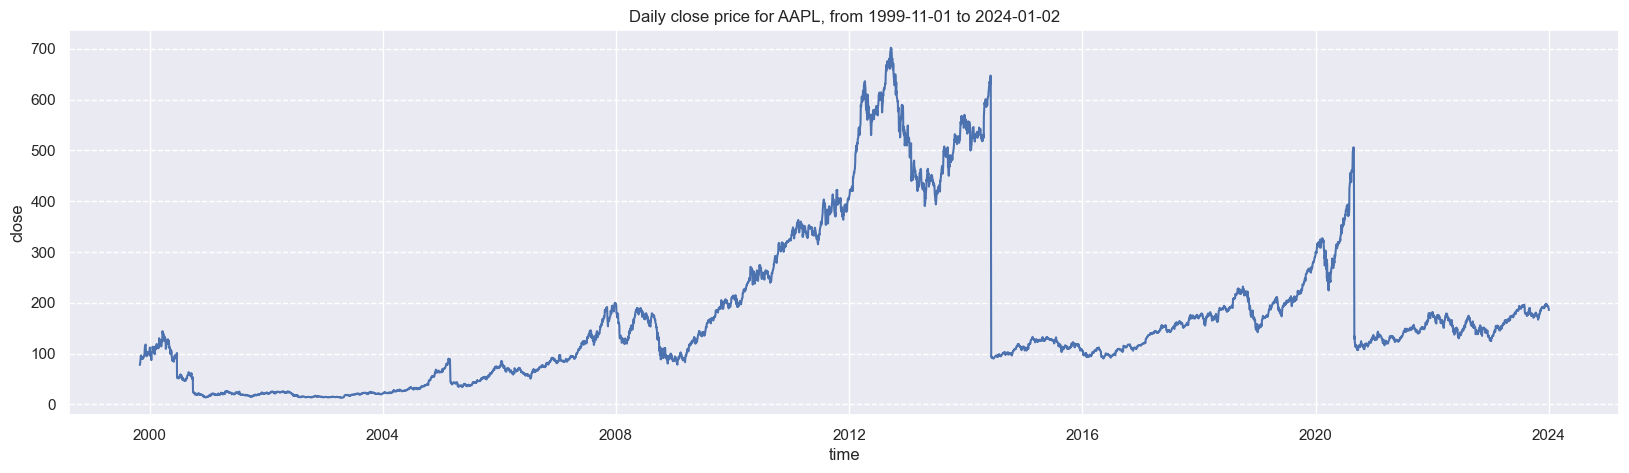

In [7]:
stock_line_plot(x_var="time", y_var="close", data=stocks)

In [8]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None
        
    
    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        return (x - self.mu) / self.sd
    
    
    def inverse_transform(self, x):
        return (x*self.sd) + self.mu


def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    
    return output[:-1], output[-1]
    
    
def prepare_data_y(x, window_size):
    output = x[window_size:]
    
    return output

scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)
data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=20)
data_y = prepare_data_y(normalized_data_close_price, window_size=20)

split_index = int(data_y.shape[0]*Config.MODELLING_CONFIG["SPLIT_RATIO"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]


def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    
    return X, y


def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["close"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n



def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f"sin_{col_name}" : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f"cos_{col_name}" : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
        }
    return df.assign(**kwargs).drop(columns=[col_name])


def is_holiday(date):
    my_holidays = holidays.MY()
    date = date.replace(hour = 0)
    return 1 if (date in my_holidays) else 0


def add_holiday_col(df):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))


def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()


def inverse_transform(df, scaler, stocks_fs, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
        
    return df

In [9]:
stocks_fs = stocks[["close"]]

stocks_fs_timelags = generate_time_lags(stocks_fs, n_lags=100)

df_features = (stocks_fs
               .assign(hour=stocks_fs.index.hour)
               .assign(day=stocks_fs.index.day)
               .assign(month=stocks_fs.index.month)
               .assign(day_of_week=stocks_fs.index.dayofweek)
               )
df_features = generate_cyclical_features(df_features, "hour", 24, 0)

df_features = add_holiday_col(df_features)

def train_test_plot(date_var, train_var, test_var):
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(date_var, train_var, label="Prices (train)", color="#3D9970")
    plt.plot(date_var, test_var, label="Prices (validation)", color="#0074D9")
    plt.grid(which='major', axis='y', linestyle='--')
    plt.title("Daily close prices for " + Config.SCRAPER_CONFIG["STOCK_TICKER"] + " - showing training and validation data")
    plt.legend()
    
    return plt.show()

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[20:split_index+20] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+20:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

train_test_plot(date_var=data_date, train_var=to_plot_data_y_train, test_var=to_plot_data_y_val)

In [10]:
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape:", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape:", dataset_val.x.shape, dataset_val.y.shape)

Train data shape: (5454, 20, 1) (5454,)
Validation data shape: (607, 20, 1) (607,)


In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        
        return out

In [12]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        
        return out

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        
    
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [14]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [15]:
class Optimization:
    """Optimization is a helper class that wraps all the training, validation and prediction.
    
    Optimization takes model, loss function, optimizer function learning scheduler (optional), early stopping
    as inputs. In returns, it provides a framework to train and validate the models, then predict future values
    based on the model
    
    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
        
    def train_step(self, x: torch.Tensor, y: torch.Tensor):
        """This method train_step completes one step of training
        
        Given the features (x) and the target values (y) tensors, this method completes one step of
        the training. First, it activates the train mode to enable backpropagation. After generating the
        predicted values (yhat) by doing forward propagation, it calculates the loss by using the loss
        function. Then, it computes the gradients by doing back propagation and updates the weights by
        calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        Returns:
            loss.item(): Loss values
        """
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()
        
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss.item()
    
    
    def train(self,
              train_loader: torch.utils.data.DataLoader, 
              val_loader: torch.utils.data.DataLoader, 
              batch_size: int=4, 
              n_epochs: int=50, 
              n_features: int=1):
        """The method performs the model training
        
        This methods takes in the DataLoader for training and validation, batch size for mini batch training, 
        number of epochs to train and number of features as inputs. Then, it carries out the training by
        iteratively calling the method-train_step for n_epochs times. If early stopping is enabled, then
        it checks the stopping condition to decide whether the training needs to halt before n_epochs steps.
        Finally, it saves the model in designated path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int, optional): Batch size for mini-batch training. Defaults to 4.
            n_epochs (int, optional): Number of epochs. Defaults to 50.
            n_features (int, optional): Number of feature columns. Defaults to 1.
        """
        model_name = self.model.__class__.__name__
        model_path = os.path.join(Config.FILES["MODELS_DIR"], "stocks", f"{model_name}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
        
        if not Path(model_path).exists():
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(Config.MODELLING_CONFIG["DEVICE"])
                y_batch = y_batch.to(Config.MODELLING_CONFIG["DEVICE"])
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(Config.MODELLING_CONFIG["DEVICE"])
                    y_val = y_val.to(Config.MODELLING_CONFIG["DEVICE"])
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
                
        torch.save(self.model.state_dict(), model_path)
        
        
    def evaluate(self, 
                 test_loader: torch.utils.data.DataLoader, 
                 batch_size: int=1, 
                 n_features: int=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.
        
        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoade): DataLoader that stores test data
            batch_size (int, optional): Batch size for mini-batch training. Defaults to 1.
            n_features (int, optional): Number of feature columns. Defaults to 1.

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.
        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(Config.MODELLING_CONFIG["DEVICE"])
                y_test = y_test.to(Config.MODELLING_CONFIG["DEVICE"])
                self.model.eval()
                yhat = self.model(x_test)
                yhat = yhat.cpu().detach().numpy()
                predictions.append(yhat)
                y_test = y_test.cpu().detach().numpy()
                values.append(y_test)
                
        return predictions, values
    
    
    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.style.use("ggplot")
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [16]:
def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_results = pd.DataFrame(data={"close": vals, "predictions": preds}, index=df_test.head(len(vals)).index)
    df_results = df_results.sort_index()
    df_results = inverse_transform(scaler, df_results, [["close", "predictions"]])
    
    return df_results


def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
        
    return df


def calculate_metrics(df):
    result_metrics = {
        "mae": mean_absolute_error(df["close"], df["predictions"]),
        "rmse": mean_squared_error(df["close"], df["predictions"]) ** 0.5,
        "r2": r2_score(df["close"], df["predictions"])
    }
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    
    return result_metrics


def build_baseline_model(df, test_ratio, target_col):
    from sklearn.linear_model import LinearRegression
    
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["predictions"] = predictions
    result = result.sort_index()
    
    return result


def train_model(model_name, x_train, train_loader, val_loader, test_loader_one):
    model_params = {
        "input_dim": len(x_train.columns),
        "hidden_dim": Config.MODELLING_CONFIG["HIDDEN_LAYER_SIZE"],
        "layer_dim": Config.MODELLING_CONFIG["NUM_LSTM_LAYERS"],
        "output_dim": Config.MODELLING_CONFIG["OUTPUT_SIZE"],
        "dropout_prob": Config.MODELLING_CONFIG["DROP_OUT"]
    }
    
    model = get_model(model_name, model_params)
    loss_fn = nn.MSELoss(reduction="mean")
    optimizer = optim.Adam(model.parameters(), 
                           lr=Config.MODELLING_CONFIG["LEARNING_RATE"], 
                           weight_decay=Config.MODELLING_CONFIG["WEIGHT_DECAY"]
                           )
    
    opt = Optimization(model=model.to(Config.MODELLING_CONFIG["DEVICE"]), loss_fn=loss_fn, optimizer=optimizer)
    opt.train(train_loader, val_loader, 
              batch_size=Config.MODELLING_CONFIG["BATCH_SIZE"], 
              n_epochs=Config.MODELLING_CONFIG["NUM_EPOCH"], 
              n_features=model_params["input_dim"]
              )
    opt.plot_losses()
    
    predictions, values = opt.evaluate(
        test_loader_one,
        batch_size=1,
        n_features=model_params["input_dim"]
    )
    
    return predictions, values


In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df=df_features, 
                                                                      target_col=Config.MODELLING_CONFIG["TARGET_VAR"], 
                                                                      test_ratio=0.2)


scale_method = "minmax"
if scale_method != "":
    print(f"{scale_method} scaling will be ran")
    scaler = get_scaler(scale_method)
    X_train_arr = scaler.fit_transform(X_train)
    X_val_arr = scaler.transform(X_val)
    X_test_arr = scaler.transform(X_test)
    
    y_train_arr = scaler.fit_transform(y_train)
    y_val_arr = scaler.transform(y_val)
    y_test_arr = scaler.transform(y_test)
else:
    print("no scaling will be ran")
    X_train_arr = X_train
    X_val_arr = X_val
    X_test_arr = X_test
    
    y_train_arr = y_train
    y_val_arr = y_val
    y_test_arr = y_test

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=Config.MODELLING_CONFIG["BATCH_SIZE"], shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=Config.MODELLING_CONFIG["BATCH_SIZE"], shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=Config.MODELLING_CONFIG["BATCH_SIZE"], shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

minmax scaling will be ran


In [18]:
def plot_predictions(df_result, df_baseline):
    data = []
    
    value = go.Scatter(
        x=df_result.index,
        y=df_result.close,
        mode="lines",
        name="close",
        marker=dict(),
        text=df_result.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    baseline = go.Scatter(
        x=df_baseline.index,
        y=df_baseline.predictions,
        mode="lines",
        line={"dash": "dot"},
        name="linear regression",
        marker=dict(),
        text=df_baseline.index,
        opacity=0.8,
    )
    data.append(baseline)
    
    prediction = go.Scatter(
        x=df_result.index,
        y=df_result.predictions,
        mode="lines",
        line={"dash": "dot"},
        name="predictions",
        marker=dict(),
        text=df_result.index,
        opacity=0.8,
    )
    data.append(prediction)
    
    layout = dict(
        title="Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="close", ticklen=5, zeroline=False),
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()
    

[1/100] Training loss: 0.0116	 Validation loss: 0.1046
[2/100] Training loss: 0.0278	 Validation loss: 0.0802
[3/100] Training loss: 0.0222	 Validation loss: 0.0676
[4/100] Training loss: 0.0205	 Validation loss: 0.0888
[5/100] Training loss: 0.0204	 Validation loss: 0.1206
[6/100] Training loss: 0.0227	 Validation loss: 0.0753
[7/100] Training loss: 0.0197	 Validation loss: 0.0999
[8/100] Training loss: 0.0181	 Validation loss: 0.0841
[9/100] Training loss: 0.0213	 Validation loss: 0.0798
[10/100] Training loss: 0.0212	 Validation loss: 0.0978
[50/100] Training loss: 0.0203	 Validation loss: 0.0696
[100/100] Training loss: 0.0226	 Validation loss: 0.0715


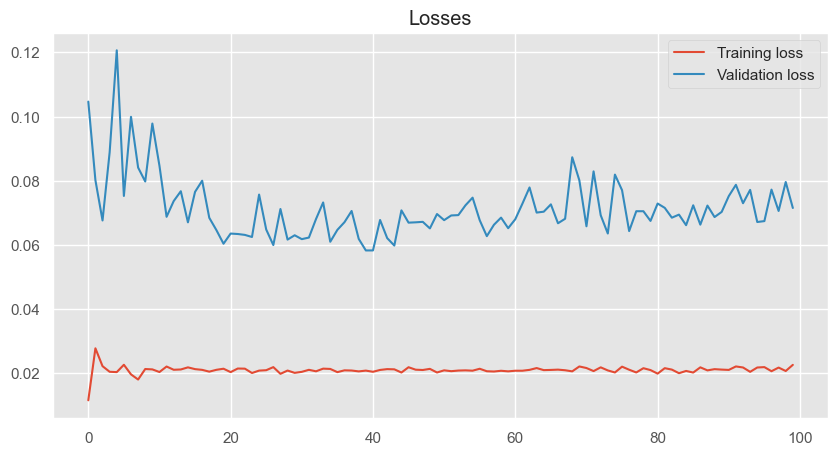

Mean Absolute Error:        135.68524
Root Mean Squared Error:    145.17381150495086
R^2 Score:                  -3.2705681816556327
{'mae': 135.68524, 'rmse': 145.17381150495086, 'r2': -3.2705681816556327}
Mean Absolute Error:        46.711234766192725
Root Mean Squared Error:    72.6341584536055
R^2 Score:                  -0.06903270761169877
{'mae': 46.711234766192725, 'rmse': 72.6341584536055, 'r2': -0.06903270761169877}


In [19]:
model_name = "rnn"
predictions, values = train_model(model_name=model_name, 
                                  x_train=X_train, 
                                  train_loader=train_loader,
                                  val_loader=val_loader, 
                                  test_loader_one=test_loader_one)
df_result = format_predictions(predictions, values, X_test, scaler)
print(calculate_metrics(df_result))

df_baseline = build_baseline_model(df_features, 0.2, "close")
print(calculate_metrics(df_baseline))

plot_predictions(df_result, df_baseline)

[1/100] Training loss: 0.0189	 Validation loss: 0.1924
[2/100] Training loss: 0.0295	 Validation loss: 0.1814
[3/100] Training loss: 0.0457	 Validation loss: 0.5482
[4/100] Training loss: 0.1092	 Validation loss: 0.2479
[5/100] Training loss: 0.1267	 Validation loss: 0.0594
[6/100] Training loss: 0.1087	 Validation loss: 0.0204
[7/100] Training loss: 0.0881	 Validation loss: 0.0266
[8/100] Training loss: 0.0957	 Validation loss: 0.0203
[9/100] Training loss: 0.0903	 Validation loss: 0.0206
[10/100] Training loss: 0.0851	 Validation loss: 0.0291
[50/100] Training loss: 0.1006	 Validation loss: 0.0768
[100/100] Training loss: 0.1044	 Validation loss: 0.0492


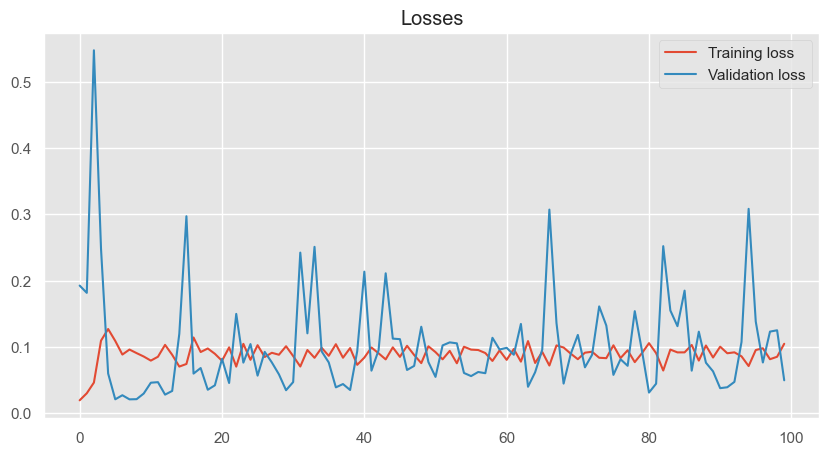

Mean Absolute Error:        107.22
Root Mean Squared Error:    115.35884908623179
R^2 Score:                  -1.6965655309894765
{'mae': 107.22, 'rmse': 115.35884908623179, 'r2': -1.6965655309894765}
Mean Absolute Error:        46.711234766192725
Root Mean Squared Error:    72.6341584536055
R^2 Score:                  -0.06903270761169877
{'mae': 46.711234766192725, 'rmse': 72.6341584536055, 'r2': -0.06903270761169877}


In [20]:
model_name = "lstm"
predictions, values = train_model(model_name=model_name, 
                                  x_train=X_train, 
                                  train_loader=train_loader,
                                  val_loader=val_loader, 
                                  test_loader_one=test_loader_one)
df_result = format_predictions(predictions, values, X_test, scaler)
print(calculate_metrics(df_result))

df_baseline = build_baseline_model(df_features, 0.2, "close")
print(calculate_metrics(df_baseline))

plot_predictions(df_result, df_baseline)

[1/100] Training loss: 0.0159	 Validation loss: 0.1026
[2/100] Training loss: 0.0234	 Validation loss: 0.1030
[3/100] Training loss: 0.0244	 Validation loss: 0.2048
[4/100] Training loss: 0.0300	 Validation loss: 0.2294
[5/100] Training loss: 0.0336	 Validation loss: 0.2387
[6/100] Training loss: 0.0369	 Validation loss: 0.2811
[7/100] Training loss: 0.0353	 Validation loss: 0.3730
[8/100] Training loss: 0.0451	 Validation loss: 0.2458
[9/100] Training loss: 0.0329	 Validation loss: 0.3205
[10/100] Training loss: 0.0484	 Validation loss: 0.4552
[50/100] Training loss: 0.0902	 Validation loss: 0.0271
[100/100] Training loss: 0.1079	 Validation loss: 0.0504


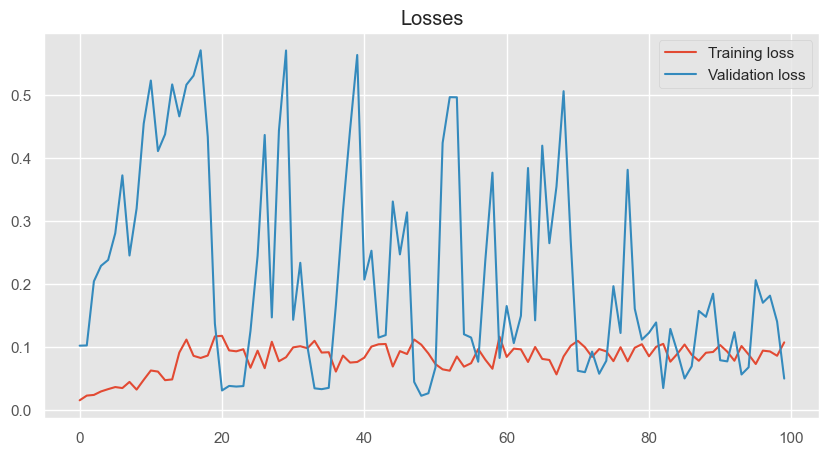

Mean Absolute Error:        108.66898
Root Mean Squared Error:    117.0513792769013
R^2 Score:                  -1.776273341479738
{'mae': 108.66898, 'rmse': 117.0513792769013, 'r2': -1.776273341479738}
Mean Absolute Error:        46.711234766192725
Root Mean Squared Error:    72.6341584536055
R^2 Score:                  -0.06903270761169877
{'mae': 46.711234766192725, 'rmse': 72.6341584536055, 'r2': -0.06903270761169877}


In [21]:
model_name = "gru"
predictions, values = train_model(model_name=model_name, 
                                  x_train=X_train, 
                                  train_loader=train_loader,
                                  val_loader=val_loader, 
                                  test_loader_one=test_loader_one)
df_result = format_predictions(predictions, values, X_test, scaler)
print(calculate_metrics(df_result))

df_baseline = build_baseline_model(df_features, 0.2, "close")
print(calculate_metrics(df_baseline))

plot_predictions(df_result, df_baseline)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size: int=1, hidden_layer_size: int=32, num_layers: int=2, output_size: int=1, dropout: float=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0.0)
            elif "weight_ih" in name:
                nn.init.kaiming_normal_(param)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param)
                
    
    def forward(self, x):
        batchsize = x.shape[0]
        
        # # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # # reshape output from hidden cell into [batch, features] for 'linear_2'
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        
        # # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:, -1]


model = LSTMModel(input_size=Config.MODELLING_CONFIG["DATA_INPUT_SIZE"], # only 1 feature, which is price
                  hidden_layer_size=Config.MODELLING_CONFIG["HIDDEN_LAYER_SIZE"],
                  num_layers=Config.MODELLING_CONFIG["NUM_LSTM_LAYERS"],
                  output_size=Config.MODELLING_CONFIG["OUTPUT_SIZE"],
                  dropout=Config.MODELLING_CONFIG["DROP_OUT"]
                  )

model = model.to(Config.MODELLING_CONFIG["DEVICE"])

In [19]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0
    
    if is_training:
        model.train()
    else:
        model.eval()
        
    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()
        
        batchsize = x.shape[0]
        
        x = x.to(Config.MODELLING_CONFIG["DEVICE"])
        y = y.to(Config.MODELLING_CONFIG["DEVICE"])
        
        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())
        
        if is_training:
            loss.backward()
            optimizer.step()
            
        epoch_loss += (loss.detach().item() / batchsize)
        
    lr = scheduler.get_last_lr()[0]
    
    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=Config.MODELLING_CONFIG["BATCH_SIZE"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=Config.MODELLING_CONFIG["BATCH_SIZE"], shuffle=False)

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=Config.MODELLING_CONFIG["LEARNING_RATE"], 
                       betas=(0.9, 0.98), 
                       eps=Config.MODELLING_CONFIG["EPS"]
                       )
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=Config.MODELLING_CONFIG["SCHEDULER_STEP_SIZE"], 
                                      gamma=Config.MODELLING_CONFIG["GAMMA"]
                                      )

In [21]:
for epoch in range(Config.MODELLING_CONFIG["NUM_EPOCH"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader, is_training=False)
    scheduler.step()
    
    print("Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}".format(epoch+1, 
                                                                             Config.MODELLING_CONFIG["NUM_EPOCH"],
                                                                             loss_train, loss_val, lr_train
                                                                             ))

Epoch[1/100] | loss train:0.094196, test:0.000175 | lr:0.010000
Epoch[2/100] | loss train:0.022050, test:0.000296 | lr:0.010000
Epoch[3/100] | loss train:0.021658, test:0.000067 | lr:0.010000
Epoch[4/100] | loss train:0.018941, test:0.000170 | lr:0.010000
Epoch[5/100] | loss train:0.020597, test:0.000213 | lr:0.010000
Epoch[6/100] | loss train:0.023602, test:0.000071 | lr:0.010000
Epoch[7/100] | loss train:0.017921, test:0.000156 | lr:0.010000
Epoch[8/100] | loss train:0.018236, test:0.000066 | lr:0.010000
Epoch[9/100] | loss train:0.019365, test:0.000192 | lr:0.010000
Epoch[10/100] | loss train:0.017632, test:0.000505 | lr:0.010000
Epoch[11/100] | loss train:0.019335, test:0.000224 | lr:0.010000
Epoch[12/100] | loss train:0.021337, test:0.000175 | lr:0.010000
Epoch[13/100] | loss train:0.017536, test:0.000163 | lr:0.010000
Epoch[14/100] | loss train:0.017440, test:0.000077 | lr:0.010000
Epoch[15/100] | loss train:0.016397, test:0.000113 | lr:0.010000
Epoch[16/100] | loss train:0.01613

In [22]:
train_dataloader = DataLoader(dataset_train, batch_size=Config.MODELLING_CONFIG["BATCH_SIZE"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=Config.MODELLING_CONFIG["BATCH_SIZE"], shuffle=False)

model.eval()

predicted_train = np.array([])
for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(Config.MODELLING_CONFIG["DEVICE"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))
    
predicted_val = np.array([])
for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(Config.MODELLING_CONFIG["DEVICE"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

## Appendix

In [9]:
train = Train(target_col="netsolar", sample_rate="hourly", location=["Bondville_IL"])
self = train

In [10]:
self.get_data()

  reading in processed train, validation and test data...
  subset data into city: ['Bondville_IL']
  multivariate forecasting...
  no data normalization applied...
  done preparing train, validation and test data for modelling...


In [11]:
self.train_data = self.train_data.reset_index().rename(columns={"index": "datetime"})
self.val_data = self.val_data.reset_index().rename(columns={"index": "datetime"})
self.test_data = self.test_data.reset_index().rename(columns={"index": "datetime"})

In [5]:
self.train_data["datetime"] = self.train_data["datetime"].apply(lambda x: x.date())
self.val_data["datetime"] = self.val_data["datetime"].apply(lambda x: x.date())
self.test_data["datetime"] = self.test_data["datetime"].apply(lambda x: x.date())

In [6]:
train_data = self.train_data.groupby(["datetime"]).mean().reset_index()
val_data = self.val_data.groupby(["datetime"]).mean().reset_index()
test_data = self.test_data.groupby(["datetime"]).mean().reset_index()

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = self.train_val_test_split(train_df=train_data,
                                                                           val_df=val_data,
                                                                           test_df=test_data)

In [91]:
def plot_univariate_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
    
    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Datetime")
    plt.ylabel("Netsolar")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
    
def plot_multivariate_time_series(data, x_var, y_var, format=".", label=None, color=None):
    sns.lineplot(data=data, x=x_var, y=y_var, color=color, label=label)

    plt.xlabel("Day", fontsize=15)
    plt.ylabel("Netsolar", fontsize=15)
    plt.legend()

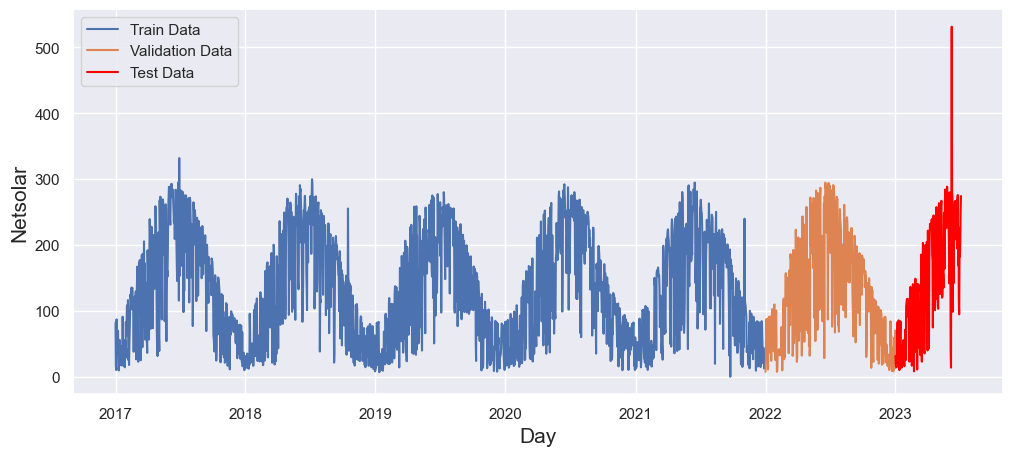

In [92]:
plt.figure(figsize=(12, 5))
plot_multivariate_time_series(data=train_data, x_var="datetime", y_var="netsolar", label="Train Data")
plot_multivariate_time_series(data=val_data, x_var="datetime", y_var="netsolar", label="Validation Data")
plot_multivariate_time_series(data=test_data, x_var="datetime", y_var="netsolar", color="red", label="Test Data")

plt.figure(figsize=(12, 5))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_val, values=y_val, label="Validation data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we can build almost any kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, horizon and window.
- **horizon** = number of timesteps to predict into future
- **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 

## Naive Forecast

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:
$$ \hat{y}_{t} = y_{t-1} $$


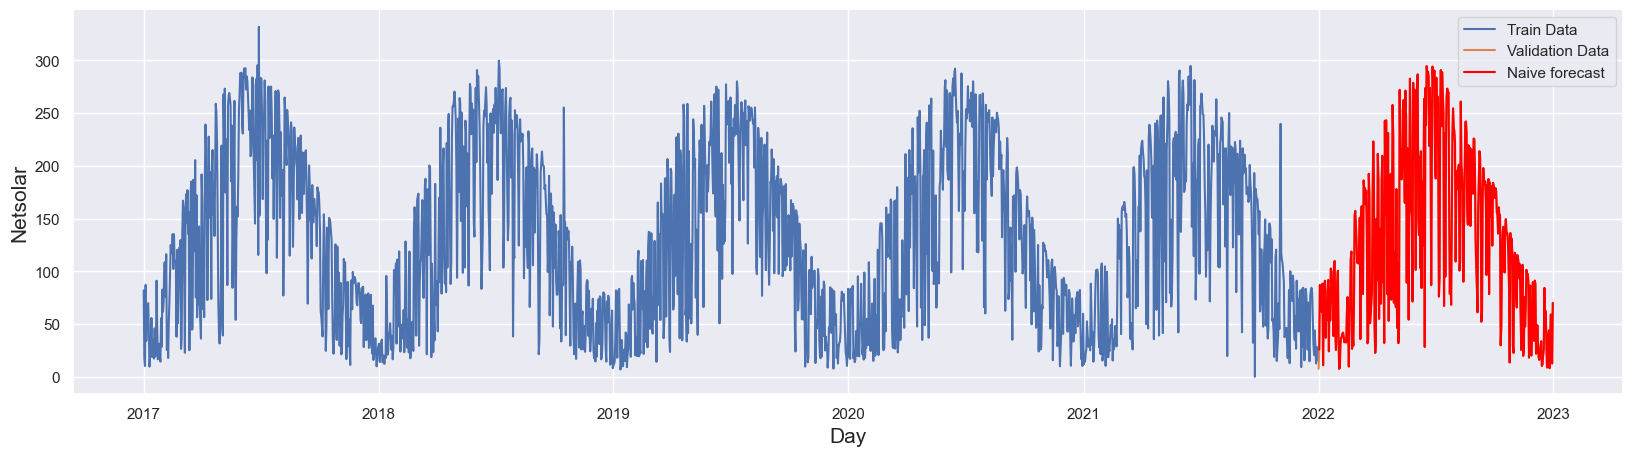

In [93]:
plt.figure(figsize=(20, 5))
plot_multivariate_time_series(data=train_data, x_var="datetime", y_var="netsolar", label="Train Data")
plot_multivariate_time_series(data=val_data, x_var="datetime", y_var="netsolar", label="Validation Data")
plot_multivariate_time_series(data=val_data[1:], x_var="datetime", y_var="netsolar", format="-", label="Naive forecast", color="red")

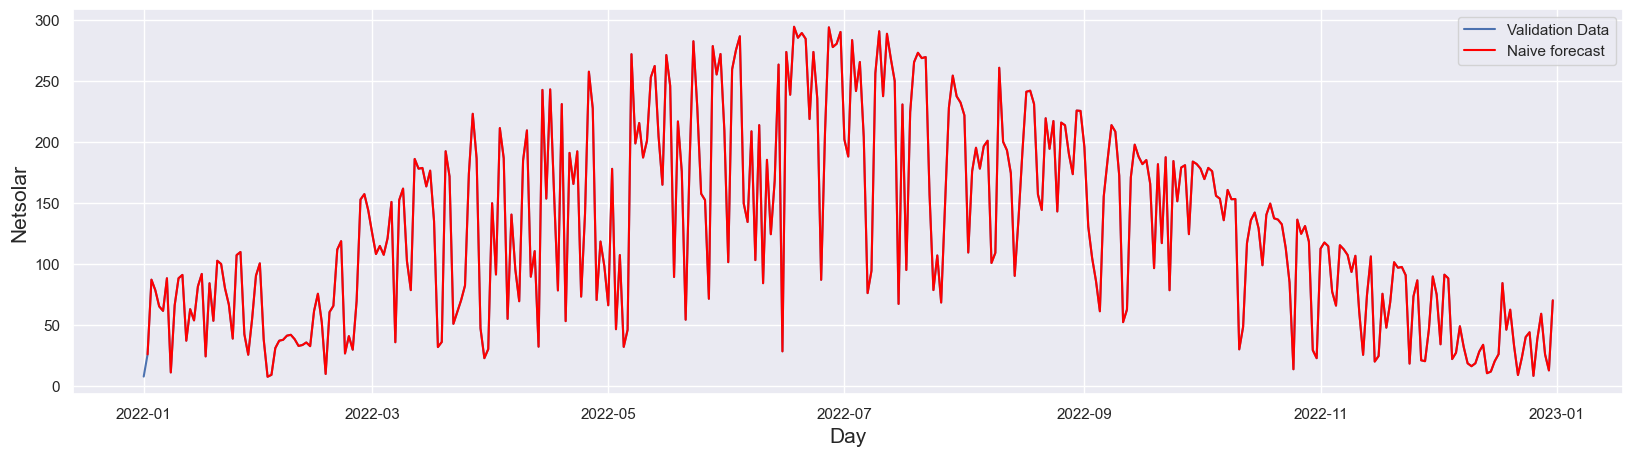

In [94]:
plt.figure(figsize=(20, 5))
plot_multivariate_time_series(data=val_data, x_var="datetime", y_var="netsolar", label="Validation Data")
plot_multivariate_time_series(data=val_data[1:], x_var="datetime", y_var="netsolar", format="-", label="Naive forecast", color="red")

## Evaluating Time Series Models

With this known, we can use regression evaluation metrics to evaluate our time series forecasts.

The main thing we will be evaluating is: **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)**? 

> 📖 **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), I'd recommend reading through here for a more in-depth overview of what we're going to practice.

For all of the following metrics, **lower is better** (for example an MAE of 0 is better than an MAE 100).

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

In [102]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season


def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [103]:
naive_forecast = y_val[:-1]

naive_results = evaluate_preds(y_true=y_val[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': array([1.82114582e+01, 6.13077087e+01, 8.66867828e+00, 1.32667389e+01,
        3.70541763e+00, 2.67964592e+01, 7.72852783e+01, 5.50899277e+01,
        2.21913910e+01, 2.74597168e+00, 5.39872208e+01, 2.58870125e+01,
        9.22541428e+00, 2.78950653e+01, 1.02481995e+01, 6.76875687e+01,
        6.00138168e+01, 3.08138199e+01, 4.92874298e+01, 2.65972137e+00,
        1.99414597e+01, 1.34397888e+01, 2.78534050e+01, 6.85335388e+01,
        2.55104065e+00, 6.74459686e+01, 1.68606930e+01, 2.92006245e+01,
        3.56969452e+01, 1.01205521e+01, 6.25576363e+01, 3.05370827e+01,
        1.57041645e+00, 2.19838181e+01, 6.02326393e+00, 7.23262787e-01,
        3.40736389e+00, 7.11944580e-01, 3.62819672e+00, 5.50631714e+00,
        7.56595612e-01, 2.09611130e+00, 3.03111267e+00, 2.87361145e+01,
        1.42922173e+01, 2.33589554e+01, 4.24813194e+01, 5.07477798e+01,
        5.17284775e+00, 4.61840286e+01, 6.88499451e+00, 9.21562500e+01,
        1.42218075e+01, 1.11723633e+01, 3.99931946e+01, 8

In [105]:
tf.reduce_mean(y_val)

<tf.Tensor: shape=(), dtype=float64, numpy=130.29773356089757>

In [104]:
tf.reduce_mean(y_val).numpy()

nan

## Single Step

In [ ]:
train_df = self.merge_train_d[self.merge_train_d["city"]=="Bondville_IL"].drop(["city"], axis=1)
val_df = self.merge_val_d[self.merge_val_d["city"]=="Bondville_IL"].drop(["city"], axis=1)
test_df = self.merge_test_d[self.merge_test_d["city"]=="Bondville_IL"].drop(["city"], axis=1)

In [4]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1,
                                train_df=train_df, val_df=val_df, test_df=test_df,
                                label_columns=["netsolar"])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, 
                         train_df=train_df, val_df=val_df, test_df=test_df,
                         label_columns=["netsolar"])

In [5]:
baseline_last = Baseline(label_index=self.column_indices["netsolar"])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [6]:
val_performance = {}
performance = {}

val_performance["Baseline - Last"] = baseline_last.evaluate(single_step_window.val)
performance["Baseline - Last"] = baseline_last.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 3ms/step - loss: 4108.3438 - mean_absolute_error: 50.0749


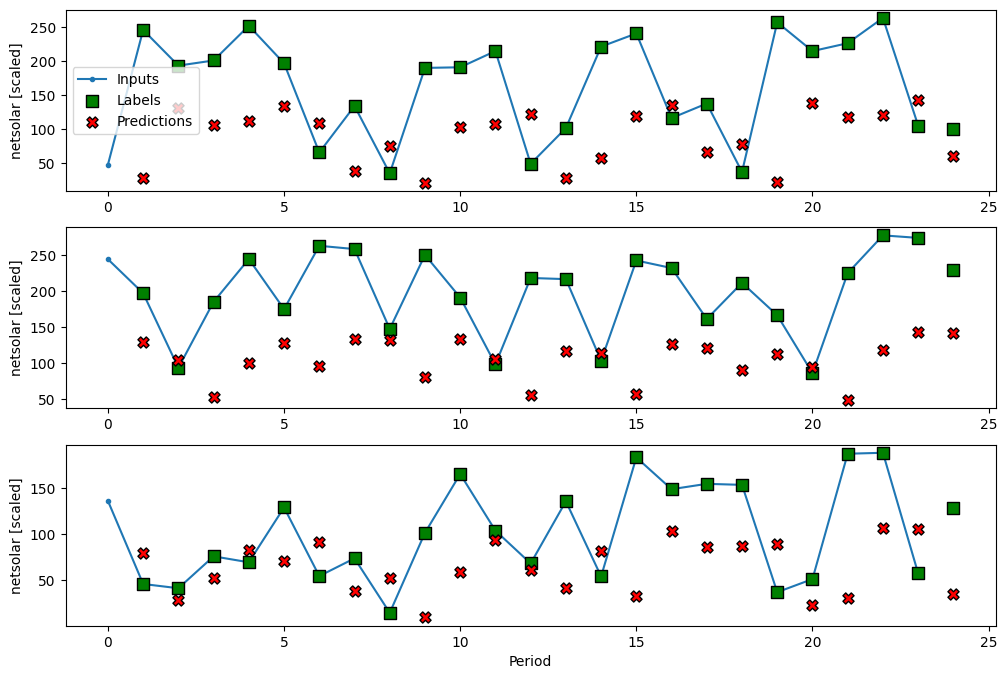

In [7]:
wide_window.plot(baseline_last)

## Multi-Step

#### Repeat last value

In [8]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, 
                          train_df=train_df, val_df=val_df, test_df=test_df,
                          label_columns=["netsolar"])

In [9]:
ms_baseline_last = MultiStepLastBaseline(label_index=self.column_indices["netsolar"])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

2/2 [==============================] - 0s 3ms/step - loss: 76740.2422 - mean_absolute_error: 165.6283


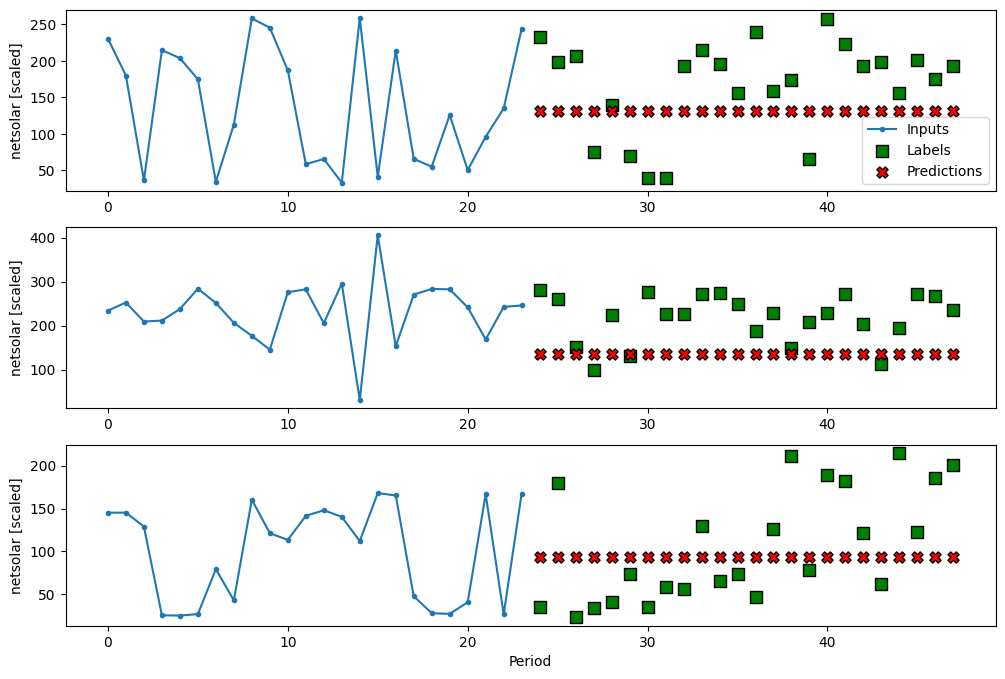

In [10]:
multi_window.plot(ms_baseline_last)

#### Repeat last season

In [11]:
ms_baseline_repeat = RepeatBaseline(label_index=self.column_indices["netsolar"])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

2/2 [==============================] - 0s 4ms/step - loss: 76887.9219 - mean_absolute_error: 166.6323


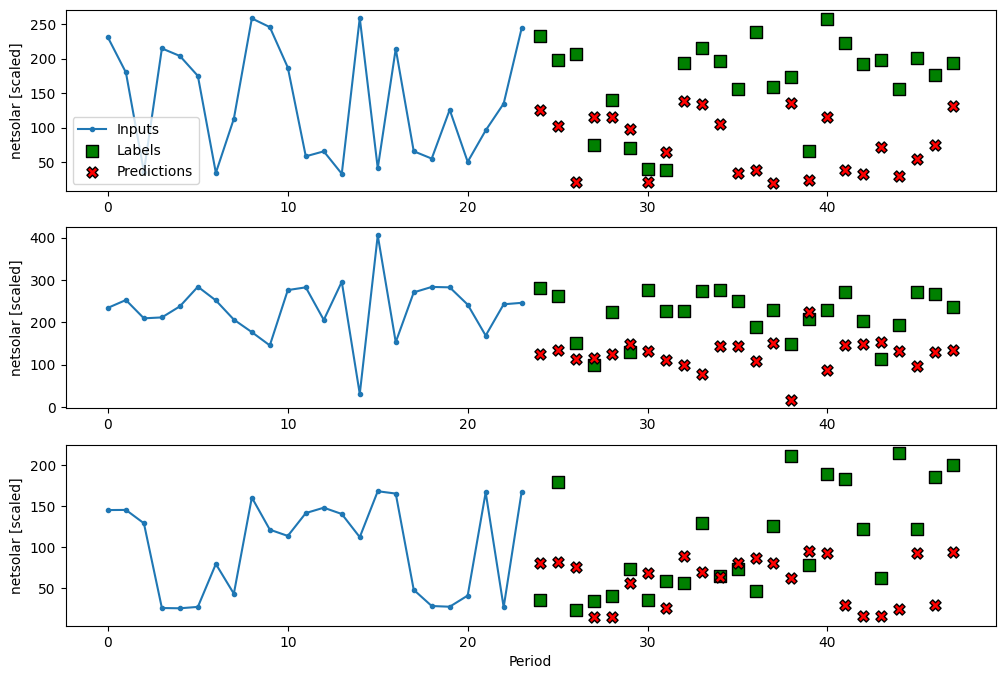

In [12]:
multi_window.plot(ms_baseline_repeat)

## Multi-Output

In [13]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, 
                                   train_df=train_df, val_df=val_df, test_df=test_df,
                                   label_columns=["netsolar", "uw_solar"]) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, 
                            train_df=train_df, val_df=val_df, test_df=test_df,
                            label_columns=["netsolar", "uw_solar"])

In [14]:
mo_baseline_last = Baseline(label_index=[3, 6])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

3/3 [==============================] - 0s 2ms/step - loss: 24627.9199 - mean_absolute_error: 135.6015


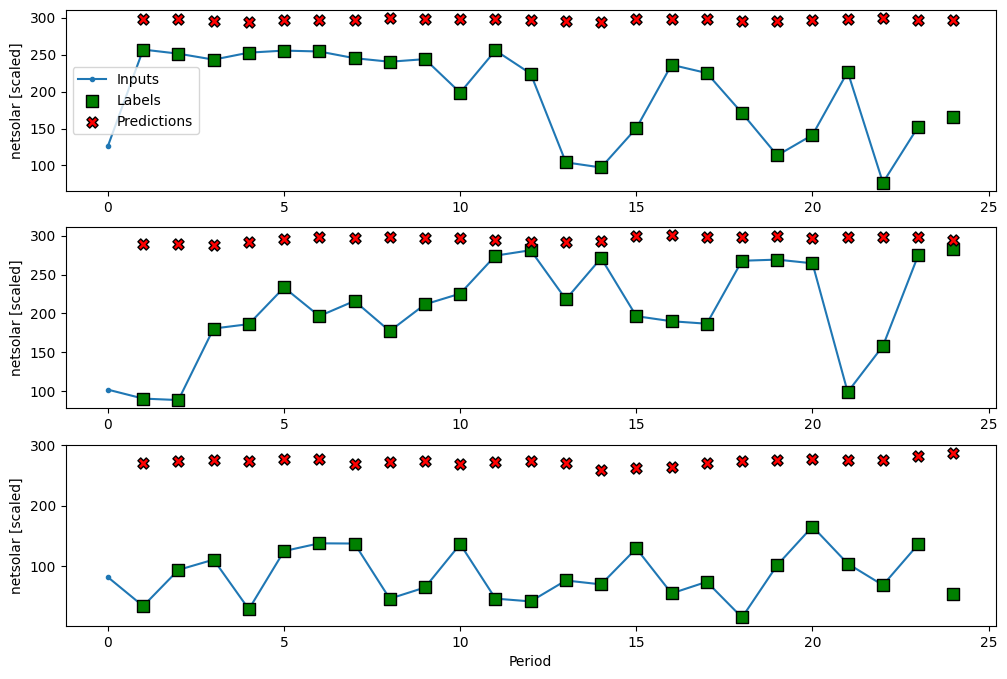

In [15]:
mo_wide_window.plot(mo_baseline_last, plot_col="netsolar")

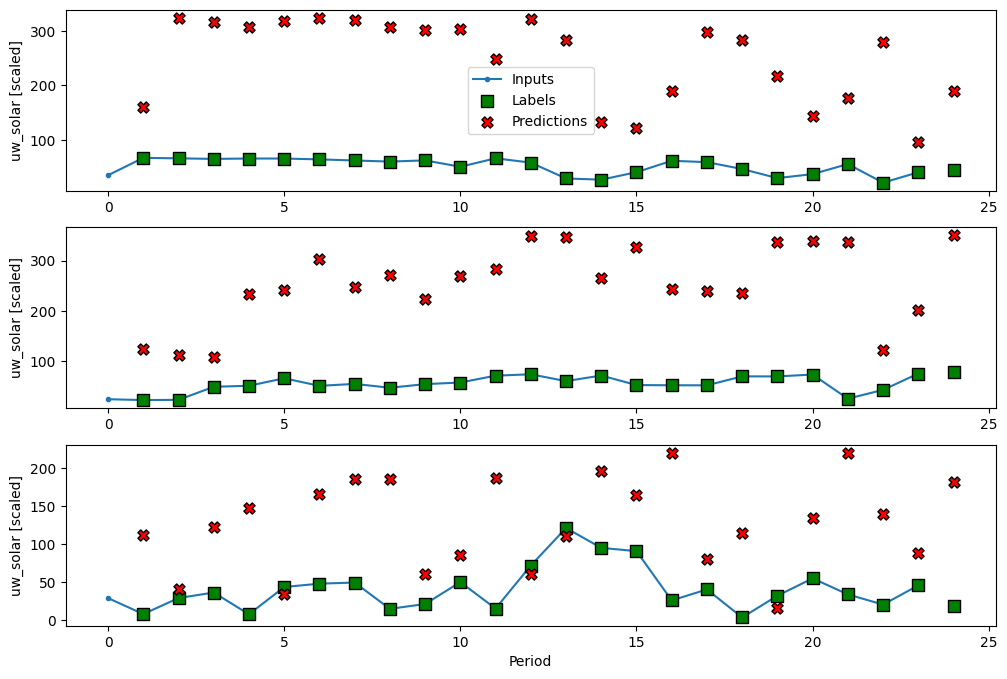

In [16]:
mo_wide_window.plot(mo_baseline_last, plot_col="uw_solar")

## Single-Step Linear Model

linear = Sequential(
    [Dense(units=1)]
)
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window, verbose=0)

## LSTM

#### Tensorflow

In [ ]:
train_d_1d = self.train_d_uni["Bondville_IL"]
val_d_1d = self.val_d_uni["Bondville_IL"]
test_d_1d = self.test_d_uni["Bondville_IL"]

scaler_d = MinMaxScaler()
scaler_d.fit(train_d_1d)
train_d_scaled = scaler_d.transform(train_d_1d)
val_d_scaled = scaler_d.transform(val_d_1d)
test_d_scaled = scaler_d.transform(test_d_1d)

In [ ]:
train_h_1d = self.train_h_uni["Bondville_IL"]
val_h_1d = self.val_h_uni["Bondville_IL"]
test_h_1d = self.test_h_uni["Bondville_IL"]

scaler_h = MinMaxScaler()
scaler_h.fit(train_h_1d)
train_h_scaled = scaler_h.transform(train_h_1d)
val_h_scaled = scaler_h.transform(val_h_1d)
test_h_scaled = scaler_h.transform(test_h_1d)

In [ ]:
def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        # # find end of this pattern
        end_ix = i + n_steps
        
        # # check if ware beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
        
    return np.array(x), np.array(y)

In [ ]:
train_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
test_seq = [13, 14, 15, 16, 17]

X_train_t, y_train_t = split_seq(train_seq, n_steps=3)
X_test_t, y_test_t = split_seq(test_seq, n_steps=3)
print(X_train_t[0], y_train_t[0])

[10 20 30] 40


In [34]:
X_train_10, y_train_10 = split_seq(train_d_scaled, n_steps=10)
X_val_10, y_val_10 = split_seq(val_d_scaled, n_steps=10)
X_test_10, y_test_10 = split_seq(test_d_scaled, n_steps=10)

X_train_10.shape, y_train_10.shape, X_test_10.shape, y_test_10.shape, X_val_10.shape, y_val_10.shape

((1816, 10, 1), (1816, 1), (83, 10, 1), (83, 1), (82, 10, 1), (82, 1))

In [35]:
X_train_30, y_train_30 = split_seq(train_d_scaled, n_steps=30)
X_val_30, y_val_30 = split_seq(val_d_scaled, n_steps=30)
X_test_30, y_test_30 = split_seq(test_d_scaled, n_steps=30)

X_train_30.shape, y_train_30.shape, X_test_30.shape, y_test_30.shape, X_val_30.shape, y_val_30.shape

((1796, 30, 1), (1796, 1), (63, 30, 1), (63, 1), (62, 30, 1), (62, 1))

In [36]:
X_train_24, y_train_24 = split_seq(train_h_scaled, n_steps=24)
X_val_24, y_val_24 = split_seq(val_h_scaled, n_steps=24)
X_test_24, y_test_24 = split_seq(test_h_scaled, n_steps=24)

X_train_24.shape, y_train_24.shape, X_test_24.shape, y_test_24.shape, X_val_24.shape, y_val_24.shape

((43800, 24, 1),
 (43800, 1),
 (2196, 24, 1),
 (2196, 1),
 (2196, 24, 1),
 (2196, 1))

In [44]:
n_steps = 10
n_features = 1

model = Sequential()
model.add(layers.LSTM(10, activation="relu", input_shape=(n_steps, n_features)))                
model.add(layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [53]:
batch_size = 10
epochs = 100
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

history = model.fit(X_train_10, y_train_10, 
                    validation_data=(X_val_10, y_val_10), callbacks=es,
                    epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/100


182/182 - 0s - loss: 0.0157 - val_loss: 0.0150 - 387ms/epoch - 2ms/step
Epoch 2/100
182/182 - 0s - loss: 0.0155 - val_loss: 0.0155 - 386ms/epoch - 2ms/step
Epoch 3/100
182/182 - 0s - loss: 0.0158 - val_loss: 0.0152 - 412ms/epoch - 2ms/step
Epoch 4/100
182/182 - 0s - loss: 0.0158 - val_loss: 0.0151 - 374ms/epoch - 2ms/step
Epoch 5/100
182/182 - 0s - loss: 0.0158 - val_loss: 0.0152 - 421ms/epoch - 2ms/step
Epoch 6/100
182/182 - 0s - loss: 0.0156 - val_loss: 0.0151 - 371ms/epoch - 2ms/step
Epoch 7/100
182/182 - 0s - loss: 0.0156 - val_loss: 0.0150 - 373ms/epoch - 2ms/step
Epoch 8/100
182/182 - 0s - loss: 0.0156 - val_loss: 0.0150 - 384ms/epoch - 2ms/step
Epoch 9/100
182/182 - 0s - loss: 0.0156 - val_loss: 0.0150 - 377ms/epoch - 2ms/step
Epoch 10/100
182/182 - 0s - loss: 0.0156 - val_loss: 0.0150 - 388ms/epoch - 2ms/step
Epoch 11/100
182/182 - 0s - loss: 0.0155 - val_loss: 0.0153 - 384ms/epoch - 2ms/step
Epoch 12/100
182/182 - 0s - loss: 0.0156 - val_loss: 0.0150 - 369ms/epoch - 2ms/step
E

In [55]:
def plot_loss(history, val_data):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=hist['epoch'],
                            y=hist['loss'],
                            name='Training Loss'),       
                         )
    if val_data == True:    
        fig.add_trace(go.Scatter(x=hist['epoch'],
                        y=hist['val_loss'],
                        name='Val Loss')
             )

    fig.update_layout(title='Training Result')
    fig.show()
    
plot_loss(history, val_data=True)

In [56]:
# # We will increase the LSTM layer and also the number of epochs.
n_steps = 10
n_features = 1
model2 = Sequential()
model2.add(layers.LSTM(50, activation="relu", input_shape=(n_steps, n_features)))                
model2.add(layers.Dense(1))
model2.compile(loss="mean_squared_error", optimizer="adam")
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [59]:
def run_model(model, X_train, y_train, X_val, y_val, epochs):
    batch_size =10
    es =EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), callbacks=es,
                        epochs=epochs, batch_size=batch_size, verbose=2)
    
    return history, model

In [60]:
history2, model2 = run_model(model2, X_train_10, y_train_10, X_val_10, y_val_10, epochs=50)
plot_loss(history2, val_data=True)

Epoch 1/50
182/182 - 1s - loss: 0.0294 - val_loss: 0.0165 - 1s/epoch - 7ms/step
Epoch 2/50
182/182 - 0s - loss: 0.0178 - val_loss: 0.0159 - 411ms/epoch - 2ms/step
Epoch 3/50
182/182 - 0s - loss: 0.0178 - val_loss: 0.0160 - 403ms/epoch - 2ms/step
Epoch 4/50
182/182 - 0s - loss: 0.0175 - val_loss: 0.0160 - 410ms/epoch - 2ms/step
Epoch 5/50
182/182 - 0s - loss: 0.0174 - val_loss: 0.0160 - 402ms/epoch - 2ms/step
Epoch 6/50
182/182 - 0s - loss: 0.0172 - val_loss: 0.0158 - 406ms/epoch - 2ms/step
Epoch 7/50
182/182 - 0s - loss: 0.0171 - val_loss: 0.0158 - 409ms/epoch - 2ms/step
Epoch 8/50
182/182 - 0s - loss: 0.0169 - val_loss: 0.0160 - 418ms/epoch - 2ms/step
Epoch 9/50
182/182 - 0s - loss: 0.0170 - val_loss: 0.0159 - 404ms/epoch - 2ms/step
Epoch 10/50
182/182 - 0s - loss: 0.0167 - val_loss: 0.0159 - 418ms/epoch - 2ms/step
Epoch 11/50
182/182 - 0s - loss: 0.0164 - val_loss: 0.0158 - 418ms/epoch - 2ms/step
Epoch 12/50
182/182 - 0s - loss: 0.0167 - val_loss: 0.0159 - 395ms/epoch - 2ms/step
Epoc

In [61]:
testPredict = model2.predict(X_test_10, batch_size=batch_size)
testPredict = scaler_d.inverse_transform(testPredict)

trainPredict = model2.predict(X_train_10, batch_size=batch_size)
trainPredict = scaler_d.inverse_transform(trainPredict)

182/182 [==============================] - 0s 934us/step


In [64]:
def create_pred_df(true_series, prediction):
    df_temp = pd.DataFrame(true_series, columns=["netsolar"]).reset_index()
    predicted_series = pd.Series(prediction.reshape(-1))
    df_temp["predicted"] = pd.Series(predicted_series, index = df_temp.index)
    
    df_pred = pd.DataFrame(true_series, columns=["netsolar"])
    df_pred["predicted"] = df_temp["predicted"].values
    
    return df_pred

In [65]:
df_pred_test = create_pred_df(test_d_1d, testPredict)
df_pred_train = create_pred_df(train_d_1d, trainPredict)

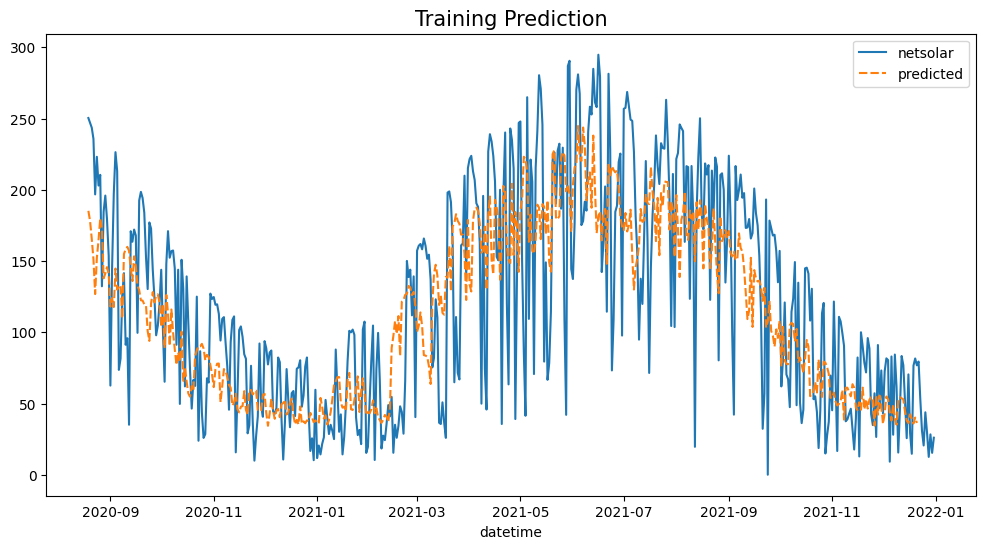

In [68]:
# Training Prediction
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred_train[-500:])
plt.title('Training Prediction', fontsize=15)
plt.legend()
plt.show();

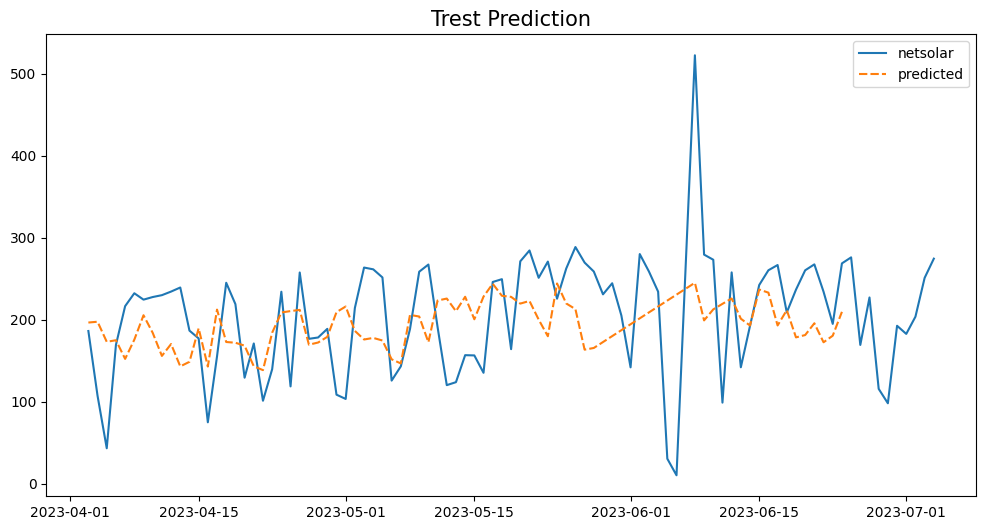

In [69]:
# Test Prediction
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred_test[-500:])
plt.title('Trest Prediction', fontsize=15)
plt.legend()
plt.show();

In [ ]:
fname = os.path.join(self.FILES[""])
model2.save('models/model2.h5')

#### Pytorch

In [61]:
from copy import deepcopy as dc
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
train_uni_df = self.train_d_uni["Bondville_IL"]
val_uni_df = self.val_d_uni["Bondville_IL"]
test_uni_df = self.test_d_uni["Bondville_IL"]

In [90]:
def _lags_feature_engineer(df:pd.DataFrame, n_steps:int, target_col:str="netsolar") -> pd.DataFrame:
    """Creating multi-periods lagging data for time series data

    :param df: input dataframe contains the target column
    :type df: pd.DataFrame
    :param n_steps: number of lags that we want to create for the target column
    :type n_steps: int
    :param target_col: target column name, defaults to "netsolar"
    :type target_col: str, optional
    :return: dataframe with number of lags features created
    :rtype: pd.DataFrame
    """
    df = dc(df)
    
    if "datetime" in df.columns:
        df.set_index("datetime", inplace=True)
        
    for i in range(1, n_steps+1):
        df[f"{target_col}_t-{i}"] = df[target_col].shift(i)
    df.dropna(inplace=True)
    
    return df


def _scaling_func(df:np.array, method:str="minmax") -> pd.DataFrame:
    """Standardize the input dataframe in numpy array form

    :param df: input dataframe in numpy array format
    :type df: np.array
    :param method: standardization method, only 'standard' and 'minmax' is available, defaults to "minmax"
    :type method: str, optional
    :return: ouytput dataframe with standardized data in numpy array format
    :rtype: pd.DataFrame
    """
    if method == "standard":
        self.scaler = StandardScaler(feature_range=(-1, 1))
    elif method == "minmax":
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
    
    df = self.scaler.fit_transform(df)
    
    return df


def _prepare_date_for_lstm(df:pd.DataFrame):
    df = _lags_feature_engineer(df=df, n_steps=self.MODELLING_CONFIG["NUMBER_OF_LAGS"], target_col=self.MODELLING_CONFIG["TARGET_COL"])
    df_np = df.to_numpy()
    df_np = _scaling_func(df=df_np, method=self.MODELLING_CONFIG["STANDARDIZATION_METHOD"])
    X = df_np[:, 1:]
    X = dc(np.flip(X, axis=1))
    y = df_np[:, 0]
    
    X = X.reshape((-1, self.MODELLING_CONFIG["NUMBER_OF_LAGS"], 1))
    y = y.reshape((-1, 1))
    
    X = torch.tensor(X).float()
    y = torch.tensor(y).float()
    
    return X, y

X_train_d, y_train_d = _prepare_date_for_lstm(df=train_uni_df)
X_val_d, y_val_d = _prepare_date_for_lstm(df=val_uni_df)
X_test_d, y_test_d = _prepare_date_for_lstm(df=test_uni_df)

X_train_d.shape, X_val_d.shape, X_test_d.shape, y_train_d.shape, y_val_d.shape, y_test_d.shape

(torch.Size([1777, 7, 1]),
 torch.Size([57, 7, 1]),
 torch.Size([50, 7, 1]),
 torch.Size([1777, 1]),
 torch.Size([57, 1]),
 torch.Size([50, 1]))

In [91]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train_d, y_train_d)
val_dataset = TimeSeriesDataset(X_val_d, y_val_d)
test_dataset = TimeSeriesDataset(X_test_d, y_test_d)

train_loader = DataLoader(train_dataset, batch_size=self.MODELLING_CONFIG["DATA_BATCH_SIZE"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=self.MODELLING_CONFIG["DATA_BATCH_SIZE"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=self.MODELLING_CONFIG["DATA_BATCH_SIZE"], shuffle=False)

In [92]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [93]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        return out
    
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [94]:
def train_one_epoch():
    model.train(True)
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print("Batch {0}, Loss: {1:.3f}".format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
            
    print()
    
    
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
    avg_loss_across_batches = running_loss / len(test_loader)

    print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
    print("***************************************************")
    print()
    
    
learning_rate = 0.01
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.096

Val Loss: 0.345
***************************************************

Epoch: 2
Batch 100, Loss: 0.070

Val Loss: 0.330
***************************************************

Epoch: 3
Batch 100, Loss: 0.070

Val Loss: 0.350
***************************************************

Epoch: 4
Batch 100, Loss: 0.068

Val Loss: 0.332
***************************************************

Epoch: 5
Batch 100, Loss: 0.068

Val Loss: 0.342
***************************************************

Epoch: 6
Batch 100, Loss: 0.070

Val Loss: 0.336
***************************************************

Epoch: 7
Batch 100, Loss: 0.066

Val Loss: 0.330
***************************************************

Epoch: 8
Batch 100, Loss: 0.067

Val Loss: 0.331
***************************************************

Epoch: 9
Batch 100, Loss: 0.066

Val Loss: 0.358
***************************************************

Epoch: 10
Batch 100, Loss: 0.064

Val Loss: 0.295
********************************

In [97]:
import seaborn as sns

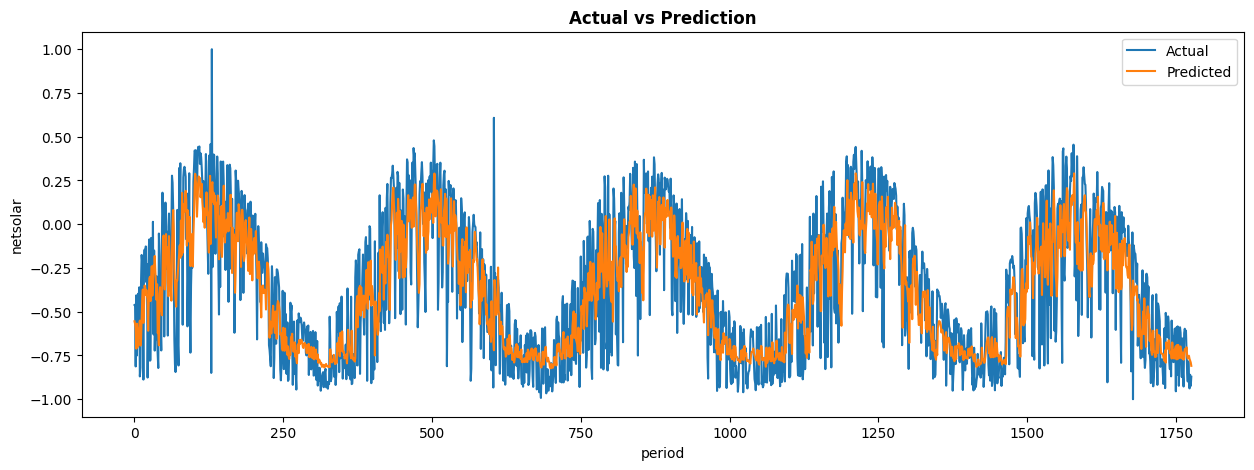

In [105]:
with torch.no_grad():
    predicted = model(X_train_d.to(device)).to("cpu").numpy()

def prediction_line_plot(actual, predict):
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.plot(actual, label="Actual")
    plt.plot(predict, label="Predicted")
    plt.xlabel("period")
    plt.ylabel("netsolar")
    plt.title("Actual vs Prediction", fontweight="bold")
    plt.legend()
    
    return plt.show()

prediction_line_plot(actual=y_train_d, predict=predicted)

In [108]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train_d.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = self.scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([72.10876029, 69.94893552, 66.78624579, ..., 40.84482161,
       39.45151392, 36.67446362])

In [111]:
dummies = np.zeros((X_train_d.shape[0], lookback+1))
dummies[:, 0] = y_train_d.flatten()
dummies = self.scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([85.03357577, 84.45619506, 36.19869011, ..., 29.58106553,
       20.68774017, 27.97933368])

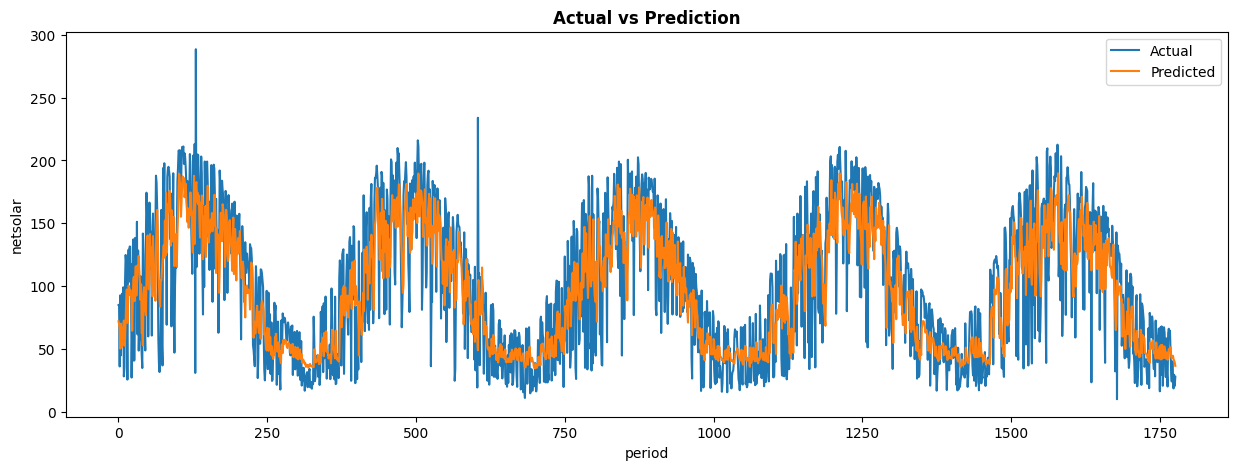

In [112]:
prediction_line_plot(actual=new_y_train, predict=train_predictions)

In [114]:
test_predictions = model(X_test_d.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test_d.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = self.scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([167.02200517, 182.38456365, 207.89822222, 220.80434721,
       157.01505323, 165.47076168, 140.1221194 , 170.98927736,
       145.01266231, 126.14177917, 179.30669037, 216.35619129,
       160.71690483, 169.02398954, 196.00702846, 213.78360805,
       219.29844038, 180.8995042 , 176.531573  , 226.71951503,
       217.72909956, 214.52942706, 190.05568258, 189.68780449,
       175.46312958, 160.50578453, 155.12612428, 215.49728367,
       187.4980567 , 184.39612554, 143.1693023 , 180.80988447,
       201.48333086, 217.27757472, 166.4188618 , 172.779316  ,
       210.6064587 , 218.80563969, 189.9258779 , 163.4618586 ,
       189.69722854, 225.41454952, 161.53383146, 185.4212233 ,
       162.34583037, 151.6946583 , 179.1988862 , 153.21881594,
       174.81179994, 210.28642259])

In [115]:
dummies = np.zeros((X_test_d.shape[0], lookback+1))
dummies[:, 0] = y_test_d.flatten()
dummies = self.scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([188.54257082, 258.38874595, 267.15146193, 190.90354017,
       120.06354252, 123.69027755, 156.61729152, 156.31270845,
       135.1168059 , 245.87506712, 249.31340204, 163.93638878,
       271.09041634, 284.31618339, 250.97930204, 270.75701567,
       225.51034964, 262.30492834, 288.499375  , 269.53166514,
       258.63479165, 230.81500324, 244.32263733, 204.99743149,
       141.7809721 , 279.92520639, 258.63319056, 234.0486803 ,
        30.32209785,  10.13788079, 242.19743101, 260.18007044,
       266.54902785, 208.7528492 , 236.48750176, 260.12888524,
       267.35798635, 233.99437587, 194.76847098, 268.56034917,
       275.90381643, 169.11534725, 226.97840265, 115.53284734,
        97.9417996 , 192.47055401, 182.55777827, 203.57298545,
       250.89096816, 274.32645771])

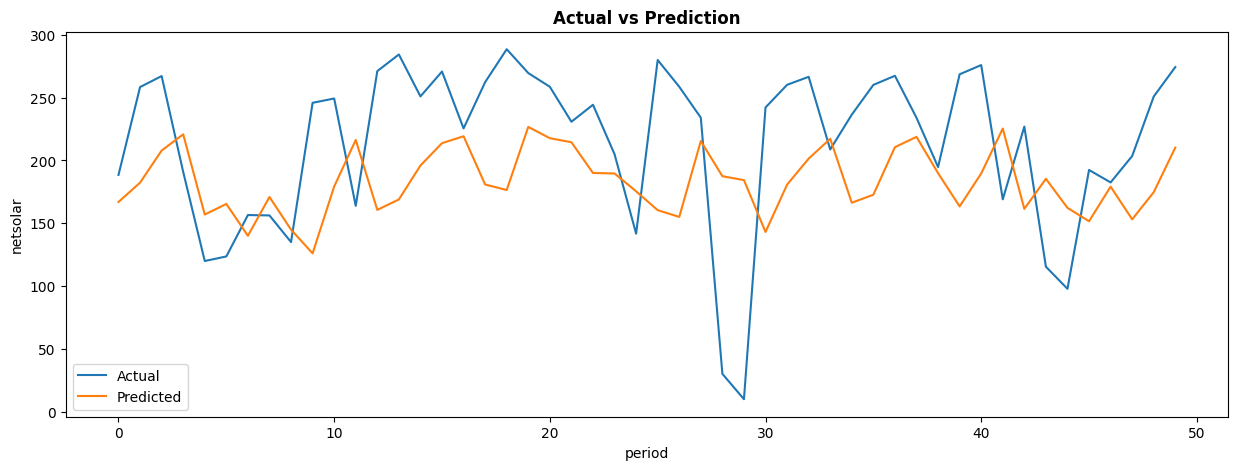

In [116]:
prediction_line_plot(actual=new_y_test, predict=test_predictions)